In [430]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


## Load data

In [431]:
df = pd.read_csv("WineQT.csv")

print(df.shape)
df.head()

(1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [432]:
print("\nInfo Data:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

df = df.drop(columns=["Id"])


Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None

Missing Values:
fixed acidity           0
volatile acidit

## Mapping Quality

In [433]:
def map_quality(q):
    if q <= 4:
        return "Low"
    elif q <= 6:
        return "Medium"
    else:
        return "High"

df["quality_group"] = df["quality"].apply(map_quality)


## Synthetic Oversampling

In [434]:
def create_synthetic_samples(data, n_samples, noise_level=0.1):
    synthetic = []
    for _ in range(n_samples):
        # Pick random sample
        idx = np.random.randint(len(data))
        base_sample = data.iloc[idx].values
        
        # Add small noise
        noise = np.random.normal(0, noise_level, base_sample.shape)
        noise *= np.std(base_sample)  # Scale noise based on std
        
        synthetic_sample = base_sample + noise
        synthetic.append(synthetic_sample)
    
    return pd.DataFrame(synthetic, columns=data.columns)

# Pisahkan per kelas
low_samples = df[df['quality_group'] == 'Low'].drop(columns=['quality_group'])
medium_samples = df[df['quality_group'] == 'Medium'].drop(columns=['quality_group'])
high_samples = df[df['quality_group'] == 'High'].drop(columns=['quality_group'])

print(f"Original counts: Low={len(low_samples)}, Medium={len(medium_samples)}, High={len(high_samples)}")

# Create synthetic samples
n_low_synthetic = 100 - len(low_samples)  # Target 100 Low samples
low_synthetic = create_synthetic_samples(low_samples.drop(columns=['quality']), n_low_synthetic)
low_synthetic['quality'] = low_samples['quality'].mode()[0]

n_high_synthetic = 50  # Add 50 High samples
high_synthetic = create_synthetic_samples(high_samples.drop(columns=['quality']), n_high_synthetic)
high_synthetic['quality'] = high_samples['quality'].mode()[0]

# Combine
low_combined = pd.concat([low_samples, low_synthetic], ignore_index=True)
high_combined = pd.concat([high_samples, high_synthetic], ignore_index=True)

# Create balanced dataframe
df_balanced = pd.concat([low_combined, medium_samples, high_combined], ignore_index=True)
df_balanced['quality_group'] = df_balanced['quality'].apply(map_quality)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"After synthetic oversampling: Low={len(low_combined)}, Medium={len(medium_samples)}, High={len(high_combined)}")
print(f"\nNew Imbalance Ratio: {df_balanced['quality_group'].value_counts().max() / df_balanced['quality_group'].value_counts().min():.2f}:1")

Original counts: Low=39, Medium=945, High=159
After synthetic oversampling: Low=100, Medium=945, High=209

New Imbalance Ratio: 9.45:1


## Train-Test Split

In [435]:
X = df.drop(columns=["quality", "quality_group"])
y = df["quality_group"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

#Prepare balanced data for training
X_balanced = df_balanced.drop(columns=['quality', 'quality_group'])
y_balanced = df_balanced['quality_group']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

## Scaling


In [436]:
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

## Inisialisasi Model

In [437]:
class_weights = {
    'Low': 10.0,
    'Medium': 1.0,
    'High': 3.0
}

best_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    class_weight=class_weights,
    bootstrap=True
)

best_model.fit(X_train_bal_scaled, y_train_bal)

RandomForestClassifier(class_weight={'High': 3.0, 'Low': 10.0, 'Medium': 1.0},
                       max_depth=20, n_estimators=500, random_state=42)

In [438]:
# Predictions
y_pred = best_model.predict(X_test_scaled)

# Classification Report
print("Classification Report on Original Test Data:")
print(classification_report(y_test, y_pred))

# Macro F1 Score
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

Classification Report on Original Test Data:
              precision    recall  f1-score   support

        High       0.97      0.94      0.95        32
         Low       1.00      0.62      0.77         8
      Medium       0.97      0.99      0.98       189

    accuracy                           0.97       229
   macro avg       0.98      0.85      0.90       229
weighted avg       0.97      0.97      0.97       229



## Visualisasi

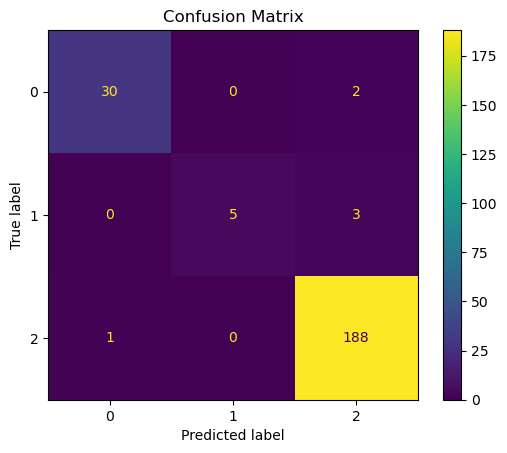

In [439]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

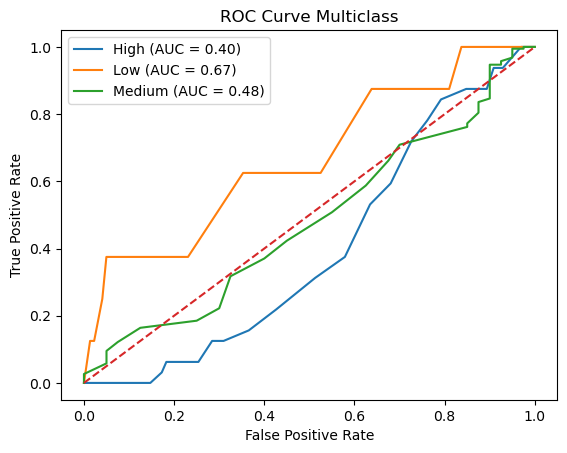

In [440]:
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_proba = best_model.predict_proba(X_test)

plt.figure()

for i, class_name in enumerate(best_model.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Multiclass")
plt.legend()
plt.show()

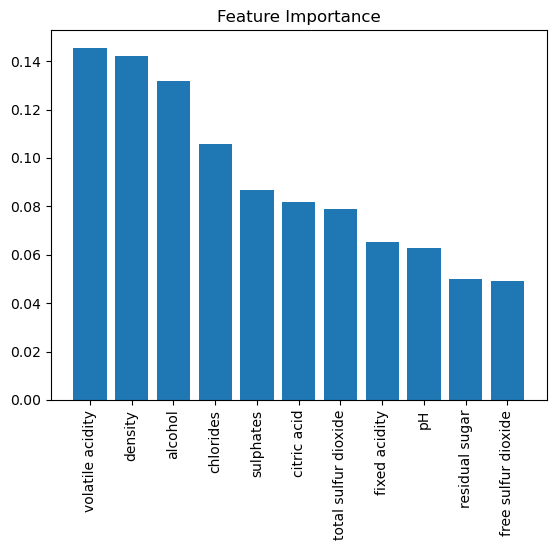

In [441]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.title("Feature Importance")
plt.show()


## Save Model

In [442]:
# Save Model
joblib.dump(best_model, 'wine_quality_model.pkl')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

print("\nModel dan Scaler berhasil disimpan!")


Model dan Scaler berhasil disimpan!


In [443]:
def prediksi_wine_quality(data_input):
    try:
        model = joblib.load('wine_quality_model.pkl')
        scaler = joblib.load('scaler.pkl')
        
        feature_names = [
            'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
            'pH', 'sulphates', 'alcohol'
        ]
        
        df_input = pd.DataFrame([data_input], columns=feature_names)
        
        data_scaled = scaler.transform(df_input)
        
        prediksi = model.predict(data_scaled)
        probabilitas = model.predict_proba(data_scaled)
        
        return prediksi[0], probabilitas
    
    except FileNotFoundError:
        return "Error: File model atau scaler tidak ditemukan. Jalankan training dulu!", None

sample_wine = [7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]

hasil, proba = prediksi_wine_quality(sample_wine)

if proba is not None:
    print("=== HASIL PREDIKSI KUALITAS WINE ===")
    print(f"Kategori Kualitas: {hasil}")
    print("Detail Probabilitas:")
    classes = joblib.load('wine_quality_model.pkl').classes_
    for i, label in enumerate(classes):
        print(f"- {label}: {proba[0][i]*100:.2f}%")

=== HASIL PREDIKSI KUALITAS WINE ===
Kategori Kualitas: Medium
Detail Probabilitas:
- High: 0.00%
- Low: 0.40%
- Medium: 99.60%
